In [14]:
import csv, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq, ifft

speed = 2670 ## m/s
measured_thickness = [
9 - 5*0.02,
8 - 2*.02,
6 - 10*0.02
] # first was 9 + 11*0.02 should be 8.9?
measured_thickness
#  cep ascan fft
# bulk1 8.9534 9.064649999999999 9.089185135135136
# bulk2 7.956599999999999 7.903199999999999 8.079275675675678
# bulk3 5.8206 5.760524999999999 6.059456756756757

[8.9, 7.96, 5.8]

In [15]:
def get_data(filename):
    with open(filename, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

    # 读取数据表格
    ceps_data_start = False
    ascan_data_start = False
    spec_data_start = False
    # data = []

    for line in lines:
        if line.startswith("Distance"):
            ceps_data_start = True
            times, ceps = [], []
            continue
        elif line.startswith("Depth ["):
            times, hfs, amps = [], [], []
            ascan_data_start = True
            continue
        elif line.startswith("Frequency"):
            freqs, ffts = [], []
            spec_data_start = True
            continue
        if ascan_data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))
        if ceps_data_start and line.strip():
            time, cep = line.strip().split()
            times.append(float(time))
            ceps.append(float(cep))
        if spec_data_start and line.strip():
            freq, fft = line.strip().split()
            freqs.append(float(freq))
            ffts.append(float(fft))
    

    # # 打印参数
    # print("[front_panel] Parameters:")
    # for key, value in parameters.items():
    #     print(f"{key}: {value}")
    if ceps_data_start:
        times, ceps = np.array(times), np.array(ceps)
        return times, ceps
    elif ascan_data_start:
        times, hfs, amps = np.array(times), np.array(hfs), np.array(amps)
        return times, hfs, amps
    else:
        freqs, ffts = np.array(freqs), np.array(ffts)
        return freqs, ffts
    

In [16]:
i = 2
times, ceps = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Ceps.dat')
atimes, hfs, amps = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Ascan.dat')
dt = np.average(np.diff(atimes))
freqs, ffts = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Spec.dat')
# times, ceps = get_data(os.getcwd()+'/bulk2_wrong/bulk2_Ceps.dat')

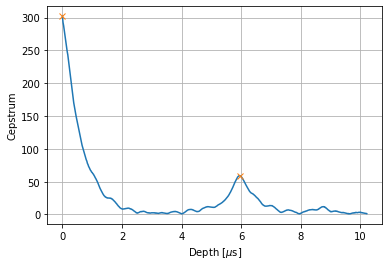

In [17]:
peaks, _ = find_peaks(ceps, distance=3/dt, height = 1)
peaks = np.concatenate(([0],peaks))
plt.plot(times,ceps)
plt.plot(ceps_peaks := times[peaks], ceps[peaks], 'x')
T_cep = np.average(np.diff(ceps_peaks)) * 1e-6
t1 = speed * T_cep/2 * 1e3

plt.xlabel(r'Depth [$\mu$s]')
plt.ylabel('Cepstrum')
plt.grid()
plt.savefig('PHY05_ceps.png')

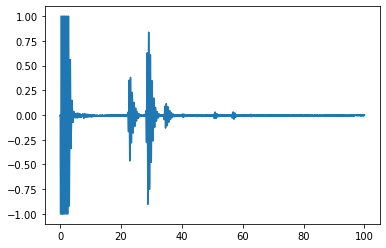

In [18]:
plt.plot(atimes, hfs)

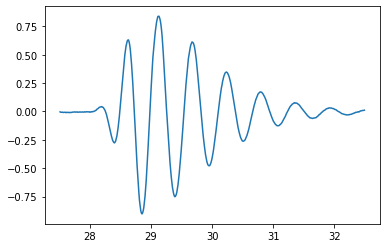

In [19]:
if i==1:
    fft_min, fft_max = 27.5, 30.
elif i==2:
    fft_min, fft_max = 27.5, 32.5
elif i==3:
    fft_min, fft_max = 20., 26.

fft_range = np.where((atimes > fft_min)&(atimes < fft_max))
plt.plot(x:=atimes[fft_range], y:=hfs[fft_range])

[1.80360721]


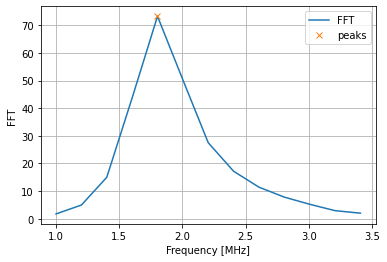

In [20]:
yf = fft(y)
N = len(x)
xf = fftfreq(N, dt)

# plt.figure(figsize=(12,8))
mask = np.where((xf>1)&(xf<3.5))

plt.plot(xf[mask], (np.abs(yf[mask])), label = 'FFT')
peaks, _ = find_peaks(np.abs(yf), distance=1)

f_peaks = xf[peaks]
y_peaks = np.abs(yf)[peaks]
mask = np.where((f_peaks > 1.5) & (f_peaks < 3))
plt.plot(a:=f_peaks[mask], y_peaks[mask],'x', label='peaks')

print(a)

plt.xlabel('Frequency [MHz]')
plt.ylabel('FFT')
plt.grid()
plt.legend()

# plt.savefig('PHY05_fft.png')

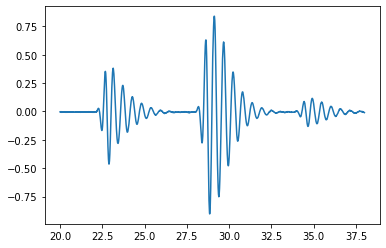

In [21]:
if i==1:
    fft_min, fft_max = 20., 50.
elif i==2:
    fft_min, fft_max = 20., 38.
elif i==3:
    fft_min, fft_max = 20., 35.

fft_range = np.where((atimes > fft_min)&(atimes < fft_max))
plt.plot(x:=atimes[fft_range], y:=hfs[fft_range])

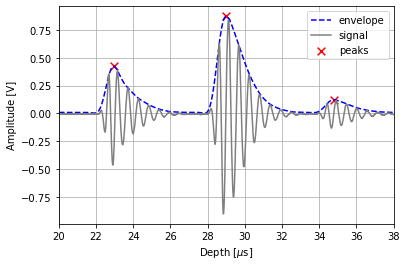

In [22]:
# plt parameters for ascan plt
plt.xlabel(r'Depth [$\mu$s]')
plt.ylabel(r'Amplitude [V]')
plt.grid()
# end


plt.plot(atimes[fft_range], amps[fft_range], c='b', label='envelope', linestyle = '--')
plt.plot(atimes[fft_range], hfs[fft_range], c='grey',label='signal')
plt.xlim(fft_min, fft_max)
peaks, _ = find_peaks(amps[fft_range], distance=2/dt, height = 0.02)
plt.scatter(atimes_peaks := atimes[fft_range][peaks], amps[fft_range][peaks], marker = 'x', s=60, c='r',label='peaks')
T_ascan = np.average(np.diff(atimes_peaks))
T_ascan
t2 = speed*T_ascan*1e-6/2*1e3
plt.legend()

# plt.savefig('PHY05_ascan.png')

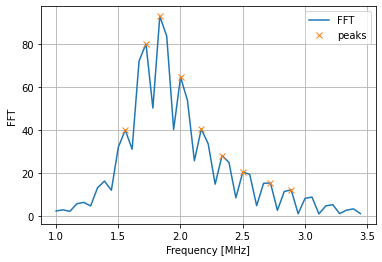

In [23]:
yf = fft(y)
N = len(x)
xf = fftfreq(N, dt)

# plt.figure(figsize=(12,8))
mask = np.where((xf>1)&(xf<3.5))

plt.plot(xf[mask], (np.abs(yf[mask])), label = 'FFT')
peaks, _ = find_peaks(np.abs(yf), distance=1)

f_peaks = xf[peaks]
y_peaks = np.abs(yf)[peaks]
mask = np.where((f_peaks > 1.5) & (f_peaks < 3))
plt.plot(a:=f_peaks[mask], y_peaks[mask],'x', label='peaks')
delta_f = np.average(np.diff(a))*1e6
T_spec = 1/delta_f
t3 = speed*T_spec/2*1e3

plt.xlabel('Frequency [MHz]')
plt.ylabel('FFT')
plt.grid()
plt.legend()

# plt.savefig('PHY05_fft.png')

In [24]:
# plt.plot(atimes[fft_range],np.abs(ifft(np.log(np.abs(yf)))))
# plt.ylim(0,0.1)

In [25]:
t_th = measured_thickness[i-1]

print('bulk\tth\tacan\terror\tfft\terror\tceps\terror')

print(f'bulk{i}\t',
      f'{t_th:.2f}\t',
      f'{t2:.2f}\t',
      f'{(t2-t_th)/t_th * 100:.1f}%\t', 
      f'{t3:.2f}\t', 
      f'{(t3-t_th)/t_th * 100:.1f}%\t',
            f'{t1:.2f}\t', 
      f'{(t1-t_th)/t_th * 100:.1f}%\t')

bulk	th	acan	error	fft	error	ceps	error
bulk2	 7.96	 7.90	 -0.7%	 8.01	 0.6%	 7.96	 -0.0%	
